In [11]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%config Completer.use_jedi = False
import pathlib
import os

In [2]:
import spacy
import scispacy
from spacy import displacy

In [3]:
from spacy.lang.en.stop_words import STOP_WORDS

In [4]:
len(STOP_WORDS)

326

In [5]:
import pandas as pd
import tqdm
import json
import re
from plotnine import *

In [6]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [7]:
gensim.__version__

'3.8.3'

In [8]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [17]:
s ="aa<i>fee<i/>fdd hellofdf<b>yes<b/>wi&gtl&ltfordii</i>."
def remove_tags(s):
    #
    s1 = re.sub("<i>|</i>|<b>|</b>|<sup>|</sup>|<sub>|</sub>|=|â€‰|&[gl]t|â‰¥|\xa0|Â|\(|\)|↵ ‡", "", s)
    return s1

In [20]:
doc = pd.read_excel ("C:/zhijuncao/R/textming/metabolomics_protomics_toxicity.xlsx")
#doc = pd.read_csv("C:/zhijuncao/R/textming/protomicscovid19.csv")
doc.dropna(subset=["abstract"], inplace=True)
doc.reset_index(drop=True, inplace=True)
print(doc.shape)
doc.head(2)

(2279, 10)


,pmid,doi,title,abstract,year,month,day,jabbrv,journal,keywords
0,33704005,10.1080/00498254.2021.1900626,FXR activation prevents liver injury induced b...,Tripterygium Glycosides Tablets (TGT) and Trip...,2021,3,11,Xenobiotica,Xenobiotica; the fate of foreign compounds in ...,Tripterygium wilfordii; bile acid metabolism; ...
1,33693819,10.1093/toxsci/kfab030,Identification of dose-dependent DNA damage an...,"1,4-Dioxane (1,4-DX) is an environmental conta...",2021,3,11,Toxicol Sci,Toxicological sciences : an official journal o...,"1,4-dioxane; DNA damage; gene set enrichment a..."


In [18]:
abstract = doc["abstract"]
#abstract = doc["abstract"]
abstract_clean = [remove_tags(i) for i in abstract]

In [14]:
nlp_sci = spacy.load("en_core_sci_lg")

In [15]:
def nlp_process(doc, model):
    doc_nlp = []
# Iterates through each article in the corpus.
    for d in tqdm.tqdm(doc):
    # Passes that article through the pipeline and adds to a new list.
        pr = model(d)
        doc_nlp.append(pr)
    return doc_nlp

In [19]:
sci = nlp_process(abstract_clean[:], nlp_sci)

100%|██████████| 2279/2279 [01:42<00:00, 22.20it/s]


In [21]:
for i in range(len(sci)):
    sci[i].user_data["title"] = f"pmid: {doc.pmid[i]}, title: {doc.title[i]}, model: sci"

In [23]:
#displacy.render(sci[1], style='ent')

In [309]:
sci_lemm_temp = [[ent.lemma_ for ent in doc if len(ent.lemma_)>2 and (ent.lemma_ not in STOP_WORDS)] for doc in sci]

In [22]:
sci_lemm_temp = [[re.sub(' ', '_',  ent.lemma_) for ent in doc.ents if len(ent.lemma_)>2 and (ent.lemma_ not in STOP_WORDS)] for doc in sci]

In [332]:
def filter_term_fre(docs, k):
    doc_filtered =[]
    for doc in docs:
        term_fre = {term: doc.count(term) for term in set(doc)}
        terms = [term for term in term_fre if term_fre[term]>k]
        terms_k = [term for term in doc if term in terms]
        doc_filtered.append(terms_k)
    return doc_filtered

In [335]:
%%time
sci_lemm1 = filter_term_fre(doc,0)

Wall time: 0 ns


In [336]:
len(sci_lemm1)

10

In [330]:
len(doc)

2279

In [311]:
%%time
sci_lemm_filter2=[]
for doc in sci_lemm_temp:
    terms = filter_term_fre(doc,1)
    sci_lemm_filter2.append([x for x in doc if x in terms])        

Wall time: 686 ms


In [323]:
len(sci_lemm)

2279

In [23]:
sci_lemm = sci_lemm_temp

In [ ]:
doc_term =[]
for i in range(len(sci_lemm)):
    doc1=[doc.pmid[i]]*len(sci_lemm[i])
    df = pd.DataFrame({"Doc":doc1, "Terms": sci_lemm[i]})
    doc_term.append(df)
    
doc_term1 = pd.concat(doc_term, ignore_index=True)
doc_term1.shape
                      
doc_term1

In [201]:
doc_term1.to_json('C:/zhijuncao/R/textming/collection_full_doc_term.json')

In [32]:
%%time
# Creates, which is a mapping of word IDs to words.,
id2word = corpora.Dictionary(sci_lemm)
print(id2word)
id2word.filter_extremes(no_below=2, no_above=1)
print(id2word)
# Turns each document into a bag of words.
corpus = [id2word.doc2bow(doc) for doc in sci_lemm]

Dictionary(35800 unique tokens: ['Tablets', 'activate', 'activation', 'agonist', 'associate_with']...)
Dictionary(9368 unique tokens: ['activate', 'activation', 'agonist', 'associate_with', 'bile_salt_export_pump']...)
Wall time: 341 ms


## Mallet

In [25]:
os.environ.update({'MALLET_HOME': r'C:/zhijuncao/py/mallet-2.0.8/'})
mallet_path =  r'C:/zhijuncao/py/mallet-2.0.8/bin/mallet' 
mallet_path

'C:/zhijuncao/py/mallet-2.0.8/bin/mallet'

In [50]:
num_topics =list(range(5, 30, 3))

In [51]:
%%time
models = []
coherence = []
perplexity = []
for k in tqdm.tqdm(num_topics):
    mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=k, id2word=id2word)
    mallet2lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet)
    models.append(mallet2lda)
    
    coherence.append(CoherenceModel(model=mallet2lda, texts=sci_lemm, dictionary=id2word, coherence='c_v').get_coherence())


100%|██████████| 9/9 [06:48<00:00, 45.42s/it]

Wall time: 6min 48s


In [36]:
import plotnine as pn

   topics  coherence
0       5   0.439223
1       8   0.437001
2      11   0.430093
3      14   0.430152
4      17   0.417309
5      20   0.438669
6      23   0.444374
7      26   0.441909
8      29   0.431390


C:\Users\ZCao\AppData\Roaming\Python\Python38\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 5 x 3 in image.
C:\Users\ZCao\AppData\Roaming\Python\Python38\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/zhijuncao/R/textming/metprotox_doc_topic_number_optimization_noblow2a.pdf


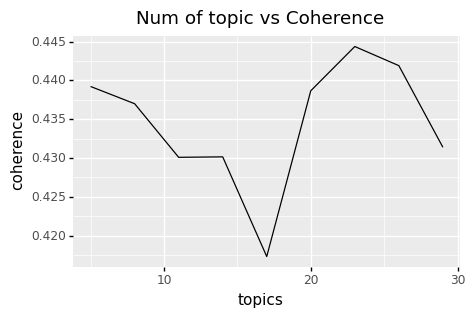

<ggplot: (161942252993)>

In [52]:

eval_para = pd.DataFrame({"topics": num_topics, "coherence":coherence})
print(eval_para)
opti_topic = (pn.ggplot(eval_para, pn.aes('topics', 'coherence'))+ pn.geom_line()+ pn.labels.ggtitle("Num of topic vs Coherence"))
pn.options.figure_size = (5, 3)
opti_topic.save('C:/zhijuncao/R/textming/metprotox_doc_topic_number_optimization_noblow2a.pdf')
opti_topic

In [42]:
def doc_topic_table(ldamodel=mallet2lda, corpus=corpus):
    sent_topics_df = pd.DataFrame()
    for i, row in tqdm.tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([i, round(prop_topic,4), int(topic_num),  topic_keywords]), ignore_index=True)
        
    sent_topics_df.columns = ['DocID','Perc_Contribution','Topic',  'Topic_Keywords']

    #contents = pd.Series(texts)
    
    sent_topics_df['Topic'] = sent_topics_df['Topic'] +1
   
    
    return(sent_topics_df)

In [64]:
DocID =doc.loc[:, ['pmid','title']]
DocID['DocID'] = list(range(len(DocID['pmid'])))
sent_topics_df= doc_topic_table(ldamodel=models[0], corpus=corpus)
doc_topics_result = DocID.merge(sent_topics_df, on='DocID', how='right')
doc_topics_result_sorted = doc_topics_result.sort_values(by=['Topic', 'Perc_Contribution'], ascending=[True, False])
doc_topics_result_sorted = doc_topics_result_sorted.astype({'Topic':'int64'})


2279it [00:38, 58.55it/s]


In [65]:
doc_topics_result_sorted.sort_values(by=['Perc_Contribution']).groupby('Topic').apply(lambda x: x.nlargest(50, 'Perc_Contribution')).to_excel('C:/zhijuncao/R/textming/metprotox_doc50_dominant_topic5_noblow2a.xlsx')

In [66]:
doc_topics_result_sorted.to_excel('C:/zhijuncao/R/textming//metprotox_doc_dominant_topic5_noblow2a.xlsx')

In [236]:
df_pivot = doc_topics_result_sorted.pivot(columns='Topic',values='Perc_Contribution', index='title')

In [347]:
#df_pivot.fillna(value=0.00001)

In [518]:
import numpy as np

In [252]:
pn.options.figure_size = (6.4, 6.8)
plot = (pn.ggplot(doc_topics_result_sorted.query('Perc_Contribution>0'), pn.aes('factor(Topic)', 'factor(title)' ))+ pn.geom_point(aes(size='Perc_Contribution')))
#plot.save('C:/zhijuncao/R/textming/metprotox_doc_topic65_dotplot.pdf')

C:\Users\ZCao\AppData\Roaming\Python\Python38\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 6.8 in image.
C:\Users\ZCao\AppData\Roaming\Python\Python38\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/zhijuncao/R/textming/science_doc_topic12_dotplot.pdf


In [243]:
import seaborn as sns
sns.set_theme(color_codes=False)
import matplotlib.pyplot as plt

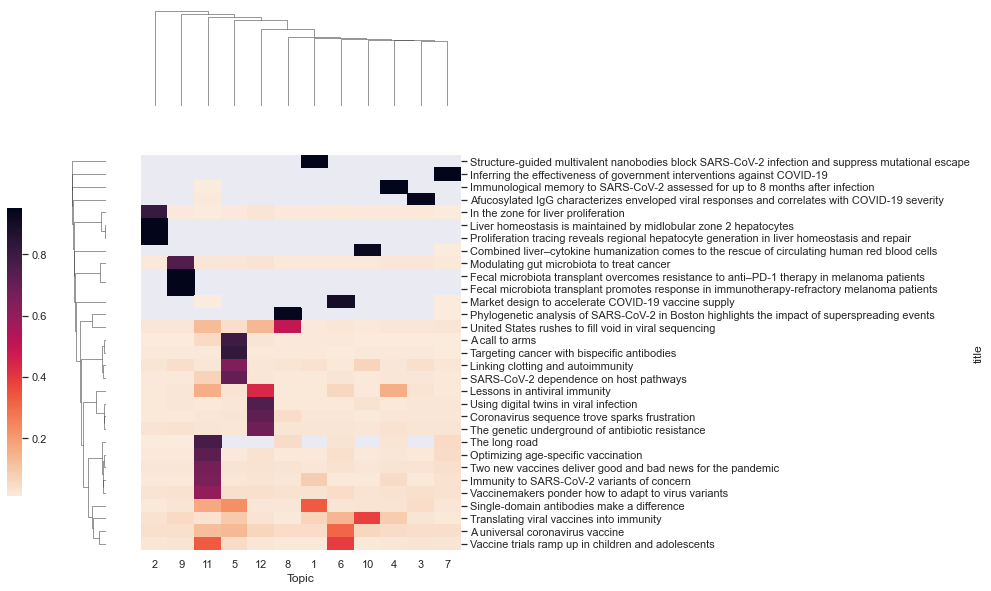

In [242]:
#iris = sns.load_dataset("iris")
#species = iris.pop("species")
g = sns.clustermap(df_pivot.fillna(0.000001),
                   figsize=(7, 10),
                   row_cluster=True,
                   robust = True,
                   mask=df_pivot.isna(),
                   cmap = 'rocket_r',
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(0, .2, .03, .4))

In [246]:
g.savefig('C:/zhijuncao/R/textming/metprotox_doc_topic_heatmap.pdf', dpi=600)

In [ ]:
dominat_sorted

In [61]:
vismallet = pyLDAvis.gensim.prepare(models[0], corpus, dictionary=id2word,  sort_topics=False)

In [62]:
pyLDAvis.save_html(vismallet, "C:/zhijuncao/R/textming/metprotox_doc_topic5_noblow2a.html")

In [63]:
vismallet

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.131464 -0.182838       1        1  20.704715
1     -0.027957 -0.275815       2        1  19.881400
2      0.211804  0.116687       3        1  19.664983
3      0.073809  0.269321       4        1  19.572198
4     -0.389120  0.072645       5        1  20.176704, topic_info=            Term         Freq        Total Category  logprob  loglift
212      protein  1964.000000  1964.000000  Default  30.0000  30.0000
53      exposure  1066.000000  1066.000000  Default  29.0000  29.0000
118   metabolite  1541.000000  1541.000000  Default  28.0000  28.0000
140       target   736.000000   736.000000  Default  27.0000  27.0000
48        effect  1053.000000  1053.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
87     biomarker   424.937591   916.831136   Topic5  -4.2326   0.8317
24     potential   412.267433   878.324915   Topic5  -4.2629   0.8443
67   metabolomic   452.227161  1235.490074   Topic5  -4.1704   0.5956
496      complex   154.965773   183.246211   Topic5  -5.2414   1.4330
32      toxicity   396.673393  3399.475126   Topic5  -4.3015  -0.5476

[395 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
147       5  1.026033        9-hode
856       2  0.985986         India
1280      3  1.000133     abundance
602       4  1.000964      abundant
83        3  0.998845  accumulation
...     ...       ...           ...
782       3  0.994124         water
82        1  0.019532          week
82        2  0.976609          week
37        4  0.990084  western_blot
332       1  1.001244     zebrafish

[429 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])